# TP : Implémentation de Word2Vec en Python


Dans ce TP, nous allons implémenter **Word2Vec** (modèle Skip-Gram avec Negative Sampling) pour apprendre des représentations vectorielles de mots.
La modélisation du langage nécessite de représenter les mots d’un corpus sous forme de vecteurs numériques capturant leurs relations sémantiques.
Word2Vec est un modèle qui génère ces représentations vectorielles en utilisant un réseau de neurones à une couche cachée et un entraînement basé sur le contexte des mots.

Nous allons explorer Word2Vec avec l'algorithme Skip-Gram et Negative Sampling, qui est une technique efficace pour entraîner ces représentations.

In [1]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import random


Tokenisation

In [2]:
corpus = ["Le chat est dans la maison", "Ma chambre est dans la maison"]

# Tokenisation
tokens = [mot.lower() for phrase in corpus for mot in phrase.split()]

# Création du vocabulaire
vocabulaire = list(set(tokens))
print("Vocabulaire :", vocabulaire)


Vocabulaire : ['le', 'dans', 'chat', 'maison', 'la', 'ma', 'chambre', 'est']


Création des matrices W_in et W_out

In [3]:
dim_embedding = 10  # Dimension des vecteurs
V = len(vocabulaire)  # Taille du vocabulaire

# Initialisation des matrices avec de petites valeurs aléatoires
W_in = np.random.randn(V, dim_embedding) * 0.01
W_out = np.random.randn(V, dim_embedding) * 0.01


Génération des paires (mot_central, mot_contextuel)

In [4]:
def generer_paires_skipgram(tokens, fenetre=2):
    paires = []
    for i, mot_central in enumerate(tokens):
        start = max(0, i - fenetre)
        end = min(len(tokens), i + fenetre + 1)
        for j in range(start, end):
            if i != j:
                paires.append((mot_central, tokens[j]))
    return paires

paires = generer_paires_skipgram(tokens)
print("Exemples de paires générées :", paires[:5])


Exemples de paires générées : [('le', 'chat'), ('le', 'est'), ('chat', 'le'), ('chat', 'est'), ('chat', 'dans')]


Sélection des mots négatifs (Negative Sampling)

In [8]:
# Calcul des fréquences des mots
compte_mots = Counter(tokens)
total = sum([compte_mots[w]**(3/4) for w in vocabulaire])
proba = {w: (compte_mots[w]**(3/4)) / total for w in vocabulaire}

def choisir_mots_negatifs(mot_central, k=5):
    mots_negatifs = np.random.choice(vocabulaire, size=k, replace=False, p=[proba[w] for w in vocabulaire])
    return [mot for mot in mots_negatifs if mot != mot_central]

mots_negatifs = choisir_mots_negatifs("chat", k=5)
print("Mots négatifs sélectionnés :", mots_negatifs)

Mots négatifs sélectionnés : ['maison', 'ma', 'chambre', 'la']


Entraînement du modèle Word2Vec

In [6]:
learning_rate = 0.01
epochs = 100

def entrainer_model():
    for epoch in range(epochs):
        for mot_central, mot_contextuel in paires:
            v_central = W_in[vocabulaire.index(mot_central)]
            u_contextuel = W_out[vocabulaire.index(mot_contextuel)]

            # Produit scalaire + Sigmoïde
            score = np.dot(v_central, u_contextuel)
            prob = 1 / (1 + np.exp(-score))
            erreur = 1 - prob

            # Mise à jour des poids
            W_in[vocabulaire.index(mot_central)] += learning_rate * erreur * u_contextuel
            W_out[vocabulaire.index(mot_contextuel)] += learning_rate * erreur * v_central

            # Negative Sampling
            mots_negatifs = choisir_mots_negatifs(mot_central, k=5)
            for mot_negatif in mots_negatifs:
                u_negatif = W_out[vocabulaire.index(mot_negatif)]
                score_neg = np.dot(v_central, u_negatif)
                prob_neg = 1 / (1 + np.exp(-score_neg))
                erreur_neg = 0 - prob_neg

                # Mise à jour des poids (éloignement)
                W_in[vocabulaire.index(mot_central)] += learning_rate * erreur_neg * u_negatif
                W_out[vocabulaire.index(mot_negatif)] += learning_rate * erreur_neg * v_central

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs} terminée.")

entrainer_model()

Epoch 0/100 terminée.
Epoch 10/100 terminée.
Epoch 20/100 terminée.
Epoch 30/100 terminée.
Epoch 40/100 terminée.
Epoch 50/100 terminée.
Epoch 60/100 terminée.
Epoch 70/100 terminée.
Epoch 80/100 terminée.
Epoch 90/100 terminée.


Visualisation des embeddings

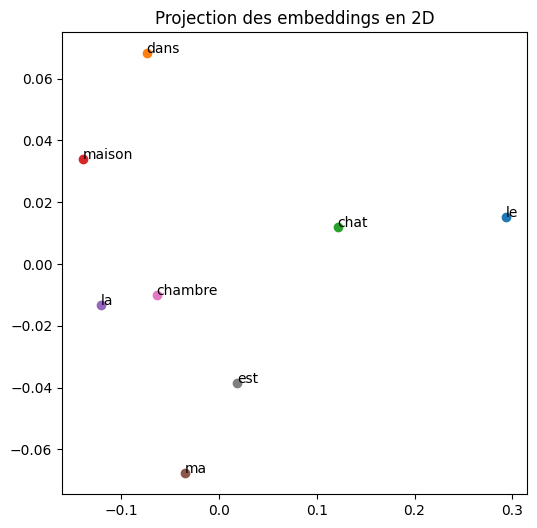

In [7]:
from sklearn.decomposition import PCA

# Réduction de dimension des embeddings
pca = PCA(n_components=2)
embeddings_2D = pca.fit_transform(W_in)

# Tracé des points
plt.figure(figsize=(6, 6))
for i, mot in enumerate(vocabulaire):
    plt.scatter(embeddings_2D[i, 0], embeddings_2D[i, 1])
    plt.annotate(mot, (embeddings_2D[i, 0], embeddings_2D[i, 1]))
plt.title("Projection des embeddings en 2D")
plt.show()

Les mots proches sur le graphe sont censés être sémantiquement liés.
Par exemple, si "chat" et "maison" sont proches, cela signifie que dans le corpus d'entraînement, ces mots apparaissent souvent ensemble.
Si des mots comme "dans" et "est" sont aussi regroupés, c’est parce qu’ils apparaissent souvent dans des contextes similaires.

Pourquoi certains mots sont éloignés ?

Si "chambre" est loin de "chat", cela signifie que dans ce corpus particulier, "chambre" n'est pas aussi souvent utilisé avec "chat".

Les mots comme "dans", "la", "est" sont des mots courants et peuvent avoir des significations plus générales.